In [164]:
pic_='F'
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle5 as pickle
from catboost import Pool
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score,cohen_kappa_score,roc_auc_score,log_loss
import mlflow
from mlflow.tracking import MlflowClient

In [165]:
##load_feature
fs=[]
with open('model/feature_selection/fs.pickle', 'rb') as handle:
    fs_=pickle.load(handle)
    catboost_params=fs_['catboost-wo_artificial']
    fs_cat=catboost_params['params.feature_name'].replace('[','').replace(']','').replace('\'','').replace(' ','').split(',')
    fs.extend(fs_cat)
    lgbm_params=fs_['lightgbm-wo_artificial']
    fs_lgb=lgbm_params['params.feature_name'].replace('[','').replace(']','').replace('\'','').replace(' ','').split(',')
    fs.extend(fs_lgb)
    rf_params=fs_['randomforest-wo_artificial']
    fs_rf=rf_params['params.feature_name'].replace('[','').replace(']','').replace('\'','').replace(' ','').split(',')
    fs.extend(fs_rf)
    fs=list(dict.fromkeys(fs))
    
##Load data
data_sample=pd.read_csv("gs://bps-gcp-bucket/MLST2023/preprocessing/sample_"+str(pic_) +".csv",sep=',')
data_sample=data_sample
X=data_sample[fs]
y=data_sample[['nama_valid']]
    
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2,stratify=y)

In [166]:
fs

['B1_p15',
 'B2_p15',
 'B3_p15',
 'B4_p15',
 'B5_p15',
 'B7_p15',
 'B8A_p15',
 'B11_p15',
 'B12_p15',
 'NDVI_p50',
 'NDWI_p50',
 'NDBI_p50',
 'SAVI_p50',
 'EVI_p50',
 'GNDVI_p50',
 'B6_p15',
 'B8_p15']

In [167]:
client = MlflowClient()
experiment = client.get_experiment_by_name("Modeling and Stacking")
exp_id=experiment.experiment_id
data_=mlflow.search_runs([exp_id], order_by=["metrics.f1_score DESC","metrics.log_loss ASC"])

In [46]:
data_

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cohen_kappa,metrics.log_loss,metrics.roc_auc,metrics.f1_score,params.classifier,tags.mlflow.log-model.history,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,c830f15ea0e844718450c882d0922d65,5,FINISHED,file:///home/jupyter-peta_admin/mlruns/5/c830f...,2022-07-14 08:38:48.697000+00:00,2022-07-14 08:38:51.007000+00:00,0.705036,0.787466,0.947681,0.789265,catboost,"[{""run_id"": ""c830f15ea0e844718450c882d0922d65""...",catboost,jupyter-peta_admin,/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
1,e7822b084fc845bca7591eb7724d346e,5,FINISHED,file:///home/jupyter-peta_admin/mlruns/5/e7822...,2022-07-14 08:38:55.366000+00:00,2022-07-14 08:38:59.167000+00:00,0.660945,0.700281,0.943807,0.768415,stacking cat-lgbm,"[{""run_id"": ""e7822b084fc845bca7591eb7724d346e""...",stacking,jupyter-peta_admin,/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
2,40662a9c8dfc46669ea8cb32462c7635,5,FINISHED,file:///home/jupyter-peta_admin/mlruns/5/40662...,2022-07-14 08:38:59.176000+00:00,2022-07-14 08:39:02.919000+00:00,0.653502,0.724571,0.941351,0.765870,voting cat-lgbm,"[{""run_id"": ""40662a9c8dfc46669ea8cb32462c7635""...",voting,jupyter-peta_admin,/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
3,84d562cd7f254048bc870a68c4d116e2,5,FINISHED,file:///home/jupyter-peta_admin/mlruns/5/84d56...,2022-07-14 08:38:51.016000+00:00,2022-07-14 08:38:53.595000+00:00,0.659049,0.747499,0.941459,0.765498,lightgbm,"[{""run_id"": ""84d562cd7f254048bc870a68c4d116e2""...",lightgbm,jupyter-peta_admin,/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL
4,d58a597b41fd474198cf86104c2766e5,5,FINISHED,file:///home/jupyter-peta_admin/mlruns/5/d58a5...,2022-07-14 08:38:53.603000+00:00,2022-07-14 08:38:55.358000+00:00,0.561986,0.880745,0.911324,0.715545,randomforest,"[{""run_id"": ""d58a597b41fd474198cf86104c2766e5""...",randomforest,jupyter-peta_admin,/opt/tljh/user/lib/python3.8/site-packages/ipy...,LOCAL


In [177]:
## Choose stacking because low value in log-loss and second higher f1-score
run_id='c830f15ea0e844718450c882d0922d65'
## If stacking choosen use mlflow.sklearn.load_model(run_id)
## If catboost choosen use mlflow.catboost.load_model(run_id)
## If lightgbm choosen use mlflow.lightgbm.load_model(run_id)
best_=mlflow.catboost.load_model('runs:/'+run_id+'/catboost')

In [178]:
best_ 

In [179]:
y_predict=best_.predict(valid_x)
y_predict_proba=best_.predict_proba(valid_x)

In [180]:
report_class=classification_report(valid_y,y_predict)

In [182]:
print(report_class)

              precision    recall  f1-score   support

      100101       0.91      0.86      0.88      7696
      100102       0.54      0.64      0.59      1432
      100107       0.65      0.34      0.45       758
      100108       0.55      0.62      0.58      1738
      100201       0.60      0.73      0.66       394
      100202       0.94      0.83      0.88       124
      100203       0.44      0.41      0.43       242
      100204       0.38      0.55      0.45        96
      100205       0.93      0.96      0.94      3425
      100206       0.47      0.67      0.55        83
      100301       0.89      0.85      0.87        39
      100302       0.57      0.93      0.71        88

    accuracy                           0.80     16115
   macro avg       0.66      0.70      0.67     16115
weighted avg       0.81      0.80      0.80     16115



In [183]:
print('F1 MICRO:',f1_score(valid_y, y_predict,average='micro'))
print('LOG LOSS:',log_loss(valid_y,y_predict_proba))
print('ROC AUC:',roc_auc_score(valid_y, y_predict_proba, average="weighted", multi_class="ovr"))
print('COHEN KAPPA:',cohen_kappa_score(valid_y, y_predict))

F1 MICRO: 0.7968352466645983
LOG LOSS: 0.7515680502336693
ROC AUC: 0.9498379038004653
COHEN KAPPA: 0.7150037155572275


In [173]:
print('F1 MICRO:',f1_score(valid_y, y_predict,average='micro'))
print('LOG LOSS:',log_loss(valid_y,y_predict_proba))
print('ROC AUC:',roc_auc_score(valid_y, y_predict_proba, average="weighted", multi_class="ovr"))
print('COHEN KAPPA:',cohen_kappa_score(valid_y, y_predict))

F1 MICRO: 0.8189264660254422
LOG LOSS: 0.5422536728861267
ROC AUC: 0.9661055101836331
COHEN KAPPA: 0.7350946627238164


<AxesSubplot:xlabel='PREDICTION', ylabel='TRUE'>

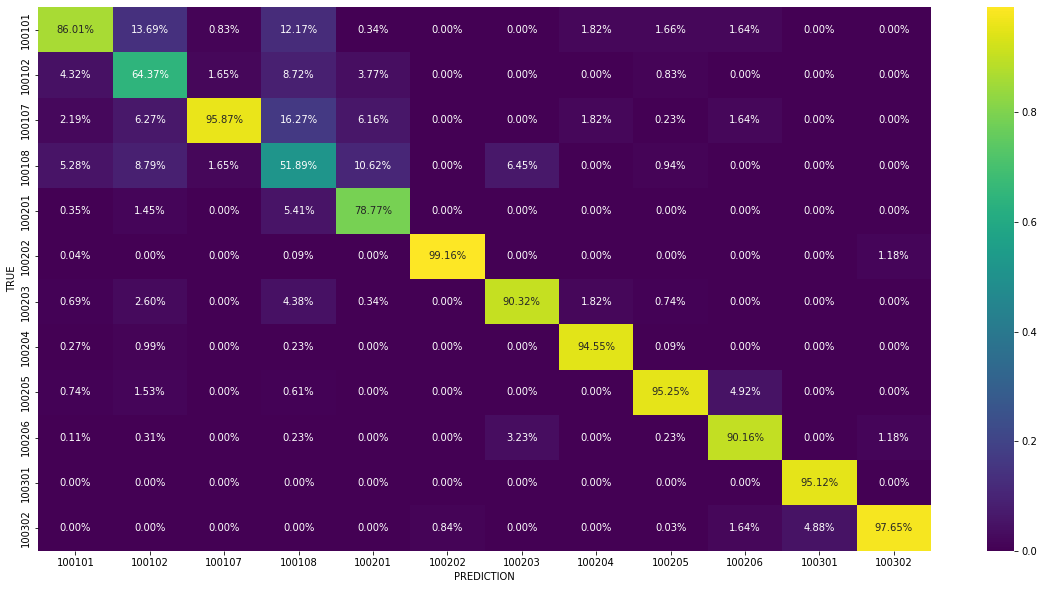

In [174]:
y_=valid_y.copy()
y_['PREDICTION']=y_predict
y_['TRUE']=y_.nama_valid
cf_matrix=y_.pivot_table(columns='PREDICTION',index='TRUE',values='nama_valid',aggfunc='count').fillna(0)
plt.figure(figsize=(20, 10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='viridis')

In [61]:
import lime
import lime.lime_tabular
from __future__ import print_function

In [139]:
t=data_sample.columns.drop(['nama_valid'])
#cek_ujicoba
PREDICTION=100101
nama_valid=100102

y_.merge(data_sample[t],left_index=True,right_index=True
        ).query('PREDICTION!=TRUE')

,nama_valid,PREDICTION,TRUE,ID_GRID,kdPIC,B1_p15,B2_p15,B3_p15,B4_p15,B5_p15,...,SAVI_p50,EVI_p50,GNDVI_p50,mahalo_dist,flag_out_mahalanobis,dbscan_out,flag_out_dbscan,isofor_out,flag_out_isolation,outlier_detect
59826,100201,100101,100201,ID-3173,F,0.125817,0.095843,0.089347,0.060022,0.099306,...,0.278880,0.509554,0.443077,27.226339,0,0,0,1,0,0
71867,100205,100101,100205,ID-3224,F,0.131475,0.097750,0.085304,0.057798,0.084185,...,0.269760,0.509476,0.422560,118.361880,-1,0,0,-1,-1,-1
48065,100107,100108,100107,ID-5085,F,0.107650,0.081671,0.075707,0.046819,0.077966,...,0.222206,0.393224,0.432640,16.644989,0,0,0,1,0,0
43546,100102,100101,100102,ID-4034,F,0.111450,0.082403,0.071492,0.043587,0.070973,...,0.275723,0.497935,0.481769,21.563988,0,0,0,1,0,0
58936,100201,100108,100201,ID-5059,F,0.113050,0.081106,0.072259,0.041453,0.073841,...,0.158291,0.286629,0.331033,38.473327,-1,0,0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41507,100102,100108,100102,ID-3086,F,0.130167,0.095254,0.084587,0.062219,0.090754,...,0.252523,0.459390,0.437772,20.589713,0,0,0,1,0,0
44820,100102,100205,100102,ID-3982,F,0.149617,0.100367,0.088514,0.062782,0.080092,...,0.021382,0.042097,-0.024528,449.031070,-1,0,0,-1,-1,-1
44986,100102,100108,100102,ID-3087,F,0.112025,0.080316,0.069440,0.042286,0.063368,...,0.343037,0.628063,0.553195,27.345168,0,0,0,-1,-1,0
50397,100108,100201,100108,ID-4656,F,0.098296,0.074041,0.064814,0.038829,0.066733,...,0.351380,0.607271,0.576516,20.066014,0,0,0,1,0,0


In [160]:
#explainer = lime.lime_tabular.LimeTabularExplainer(train_x, training_labels=train_y,
#                                                   feature_names=fs, 
#                                                   class_names=train_y.nama_valid.unique(), 
#                                                   discretize_continuous=False)
#idx=48065
#exp=explainer.explain_instance(valid_x.loc[idx,:], 
#                           best_.predict_proba, num_features=len(fs), top_labels=5)#

#exp.show_in_notebook(show_table=True, show_all=True)

In [175]:
import os
from google.cloud import storage
import pickle5 as pickle

with open('model/model-result/model_final.pickle', 'wb') as handle:
    pickle.dump([best_,fs], handle, protocol=pickle.HIGHEST_PROTOCOL)
client = storage.Client()
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'gcp_store.json'
bucket = client.get_bucket('bps-gcp-bucket')
file_name='MLST2023/model/final-model/'+pic_+'_model.pickle'
bucket.blob(file_name).upload_from_filename('model/model-result/model_final.pickle')